# 03 — Classical Baselines

Before running a single quantum circuit, we need to know what we're competing against.

This notebook establishes the classical performance ceiling across three solvers and three problem instances. Every approximation ratio reported in notebooks 04 and 05 is measured against the numbers produced here — so getting this right matters.

**Instances:**
- Problem A full graph (21 nodes, 28 edges) — exact solution known: 3728.4132
- Hardware subgraph k=8 (8 nodes, 9 edges) — exact computed here
- Problem B full graph (180 nodes, 226 edges) — no exact reference, greedy is ceiling

**Solvers:**
1. Exact brute force (ground truth where feasible)
2. Greedy one-exchange (NetworkX — the hackathon hint baseline)
3. Simulated annealing (stronger classical heuristic)
4. Goemans-Williamson SDP (theoretical 0.878 guarantee)

**Output:** `results/tables/classical_baselines_all.csv` — the benchmark anchor for all downstream notebooks.

In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

import time
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 11, 'axes.titlesize': 13})

from src.graph_utils import load_graph, bfs_subgraph, cut_value, approximation_ratio
from src.classical_solvers import (
    exact_brute_force,
    greedy_one_exchange,
    simulated_annealing,
    goemans_williamson,
)

import pathlib
RESULTS = pathlib.Path('../../results/track_1_hackathon')
(RESULTS / 'tables').mkdir(parents=True, exist_ok=True)
(RESULTS / 'plots').mkdir(parents=True, exist_ok=True)

print('imports done')

imports done


---
## 1. Load Graphs

In [2]:
GA  = load_graph('../../data/problemA.parquet')
GB  = load_graph('../../data/problemB.parquet')
hwG = bfs_subgraph(GA, target_size=8)   # k=8 hardware target from notebook 02

# Known exact MPES for Problem A full graph (from 01_eda brute force)
EXACT_A_FULL = 3728.4132

print(f'Problem A (full)    →  {GA.number_of_nodes()} nodes, {GA.number_of_edges()} edges')
print(f'HW subgraph (k=8)   →  {hwG.number_of_nodes()} nodes, {hwG.number_of_edges()} edges')
print(f'Problem B (full)    →  {GB.number_of_nodes()} nodes, {GB.number_of_edges()} edges')
print(f'\nKnown exact MPES (Problem A full): {EXACT_A_FULL}')
print(f'HW subgraph nodes: {sorted(hwG.nodes())}')

Problem A (full)    →  21 nodes, 28 edges
HW subgraph (k=8)   →  8 nodes, 9 edges
Problem B (full)    →  180 nodes, 226 edges

Known exact MPES (Problem A full): 3728.4132
HW subgraph nodes: [1, 2, 5, 7, 8, 12, 15, 20]


---
## 2. Exact Brute Force — Ground Truth

Feasible only for n ≤ 22. We run it on both Problem A (21 nodes) and the k=8 hardware subgraph to establish exact reference points that every other solver will be measured against.

In [3]:
print('Running exact brute force on Problem A (21 nodes, 2^21 = 2,097,152 partitions)...')
t0 = time.perf_counter()
exact_A = exact_brute_force(GA)
print(f'  cut value : {exact_A.cut_value:.6f}')
print(f'  runtime   : {exact_A.runtime_s:.2f}s')
print(f'  matches known MPES: {abs(exact_A.cut_value - EXACT_A_FULL) < 0.01}')

print()
print('Running exact brute force on HW subgraph (8 nodes, 2^8 = 256 partitions)...')
exact_hw = exact_brute_force(hwG)
print(f'  cut value : {exact_hw.cut_value:.6f}')
print(f'  runtime   : {exact_hw.runtime_s:.4f}s')
print(f'  optimal partition: {dict(sorted(exact_hw.partition.items()))}')

EXACT_HW = exact_hw.cut_value
print(f'\nExact references locked in:')
print(f'  EXACT_A_FULL = {EXACT_A_FULL}')
print(f'  EXACT_HW     = {EXACT_HW:.6f}')

Running exact brute force on Problem A (21 nodes, 2^21 = 2,097,152 partitions)...
  cut value : 3728.413221
  runtime   : 19.70s
  matches known MPES: True

Running exact brute force on HW subgraph (8 nodes, 2^8 = 256 partitions)...
  cut value : 1296.422475
  runtime   : 0.0008s
  optimal partition: {1: 1, 2: 1, 5: -1, 7: -1, 8: 1, 12: -1, 15: 1, 20: -1}

Exact references locked in:
  EXACT_A_FULL = 3728.4132
  EXACT_HW     = 1296.422475


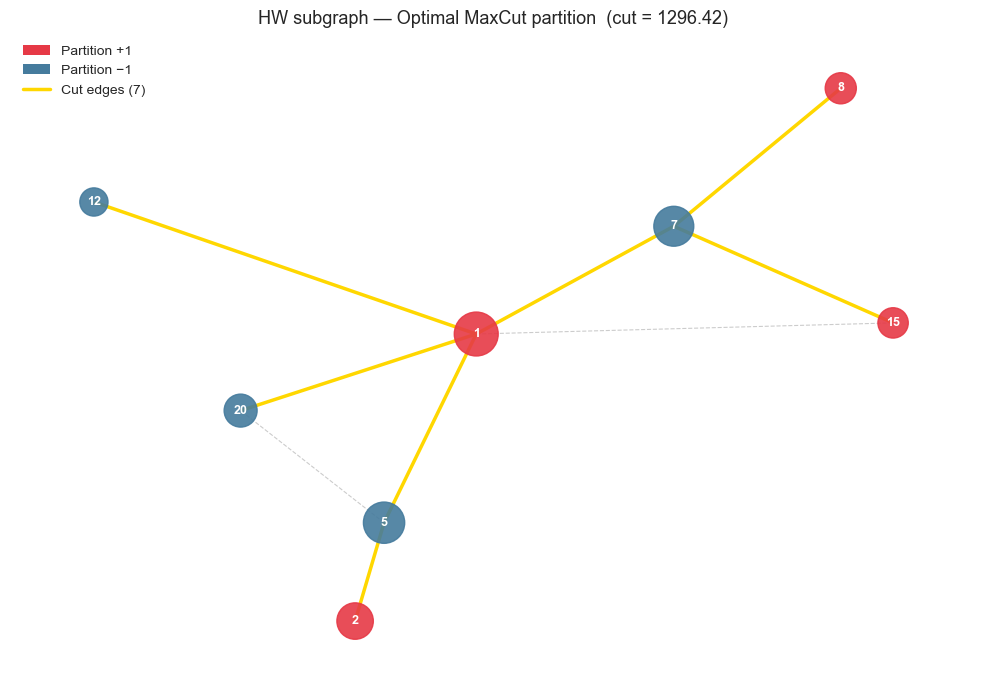

In [4]:
# Visualise optimal hw subgraph partition
from src.graph_utils import plot_optimal_cut
plot_optimal_cut(
    hwG,
    exact_hw.partition,
    exact_hw.cut_value,
    title=f'HW subgraph — Optimal MaxCut partition  (cut = {exact_hw.cut_value:.2f})',
    save_path=str(RESULTS / 'plots/baselines_hw_optimal_cut.png')
)

---
## 3. Greedy One-Exchange

The baseline explicitly mentioned in the hackathon task. NetworkX `one_exchange` starts from a random partition and greedily flips nodes that improve the cut, stopping when no single flip helps. Fast, but gets stuck in local optima.

In [5]:
# Run across all three instances
# Multiple seeds to get a distribution — one_exchange is seed-sensitive
N_SEEDS = 20
seeds   = range(N_SEEDS)

greedy_results = {}
for label, G, exact in [
    ('problemA_full', GA,  EXACT_A_FULL),
    ('hw_subgraph',   hwG, EXACT_HW),
    ('problemB_full', GB,  None),
]:
    cuts = []
    for s in seeds:
        r = greedy_one_exchange(G, seed=s)
        cuts.append(r.cut_value)
    cuts = np.array(cuts)
    best = greedy_one_exchange(G, seed=int(np.argmax(cuts)))
    if exact:
        best.approx_ratio = best.cut_value / exact
    greedy_results[label] = {
        'result'     : best,
        'cuts'       : cuts,
        'mean'       : cuts.mean(),
        'std'        : cuts.std(),
        'best'       : cuts.max(),
        'worst'      : cuts.min(),
        'exact'      : exact,
    }
    ratio_str = f'{best.approx_ratio:.4f}' if best.approx_ratio else '  N/A'
    print(f'{label:<20}  best={cuts.max():.2f}  mean={cuts.mean():.2f}  '
          f'std={cuts.std():.2f}  approx_ratio={ratio_str}')

problemA_full         best=3632.36  mean=3632.36  std=0.00  approx_ratio=0.9742
hw_subgraph           best=1296.42  mean=1296.42  std=0.00  approx_ratio=1.0000
problemB_full         best=6778.19  mean=6778.19  std=0.00  approx_ratio=  N/A


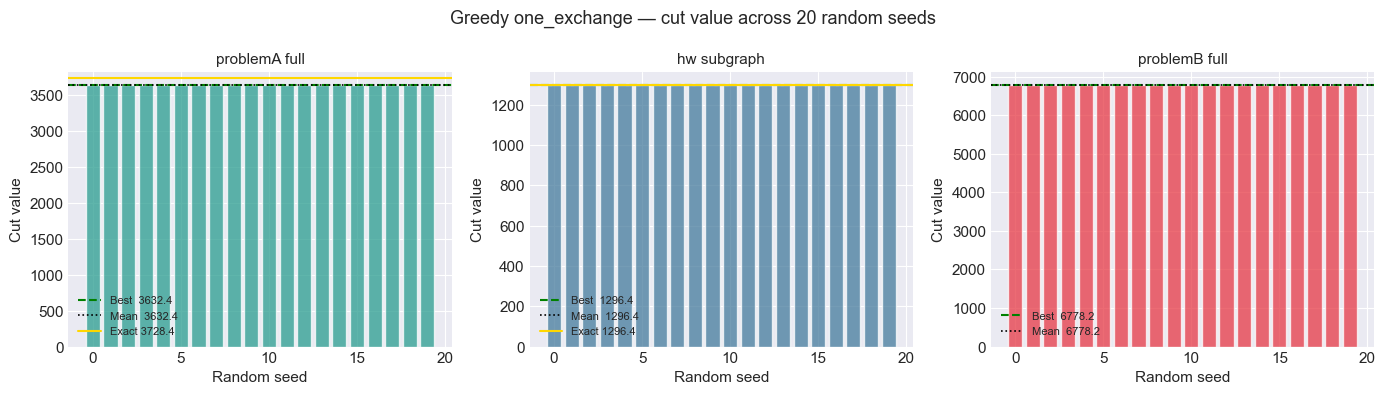

Takeaway: greedy is seed-sensitive — always report best-of-N, not single-run.


In [6]:
# Seed sensitivity — shows how much the result varies
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (label, data), color in zip(
    axes,
    greedy_results.items(),
    ['#2a9d8f', '#457b9d', '#e63946']
):
    cuts = data['cuts']
    ax.bar(range(N_SEEDS), cuts, color=color, alpha=0.75, edgecolor='white')
    ax.axhline(data['best'],  color='green',  linestyle='--', linewidth=1.5, label=f'Best  {data["best"]:.1f}')
    ax.axhline(data['mean'],  color='black',  linestyle=':',  linewidth=1.2, label=f'Mean  {data["mean"]:.1f}')
    if data['exact']:
        ax.axhline(data['exact'], color='gold', linestyle='-', linewidth=1.5, label=f'Exact {data["exact"]:.1f}')
    ax.set_title(label.replace('_', ' '), fontsize=11)
    ax.set_xlabel('Random seed')
    ax.set_ylabel('Cut value')
    ax.legend(fontsize=8)

plt.suptitle('Greedy one_exchange — cut value across 20 random seeds', fontsize=13)
plt.tight_layout()
plt.savefig(str(RESULTS / 'plots/baselines_greedy_seed_sensitivity.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print('Takeaway: greedy is seed-sensitive — always report best-of-N, not single-run.')

---
## 4. Simulated Annealing

SA explores a broader solution space than greedy by accepting worse solutions with a temperature-dependent probability. With enough iterations and a good cooling schedule it consistently outperforms greedy on MaxCut. We run multiple restarts and report best-of-N.

In [7]:
N_RESTARTS = 10
sa_results = {}

for label, G, exact in [
    ('problemA_full', GA,  EXACT_A_FULL),
    ('hw_subgraph',   hwG, EXACT_HW),
    ('problemB_full', GB,  None),
]:
    runs = []
    print(f'SA on {label} ({N_RESTARTS} restarts)...', end=' ', flush=True)
    for s in range(N_RESTARTS):
        r = simulated_annealing(
            G,
            T_start  = 50.0,
            T_end    = 0.001,
            cooling  = 0.997,
            max_iter = 80000,
            seed     = s
        )
        runs.append(r)

    cuts  = np.array([r.cut_value for r in runs])
    best_r = runs[int(np.argmax(cuts))]
    if exact:
        best_r.approx_ratio = best_r.cut_value / exact

    sa_results[label] = {
        'result' : best_r,
        'cuts'   : cuts,
        'mean'   : cuts.mean(),
        'std'    : cuts.std(),
        'best'   : cuts.max(),
        'exact'  : exact,
    }
    ratio_str = f'{best_r.approx_ratio:.4f}' if best_r.approx_ratio else '  N/A'
    print(f'best={cuts.max():.2f}  mean={cuts.mean():.2f}  '
          f'std={cuts.std():.2f}  approx_ratio={ratio_str}')

SA on problemA_full (10 restarts)... best=3687.92  mean=3583.39  std=110.44  approx_ratio=0.9891
SA on hw_subgraph (10 restarts)... best=1296.42  mean=1259.18  std=30.41  approx_ratio=1.0000
SA on problemB_full (10 restarts)... best=6793.27  mean=6628.91  std=75.19  approx_ratio=  N/A


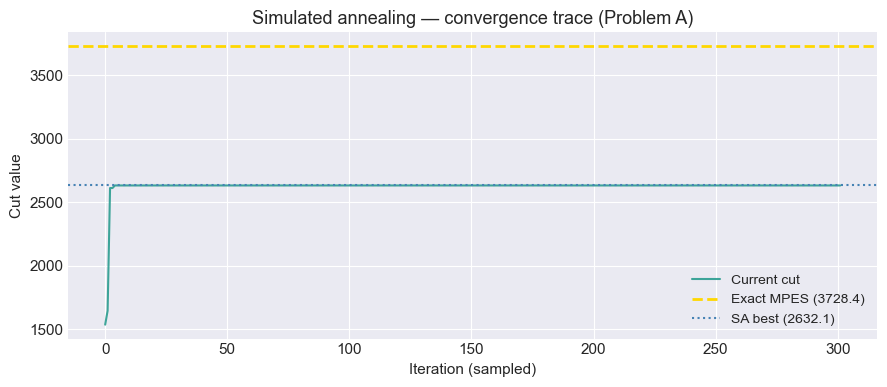

In [12]:
# SA convergence — show energy trace of best run for Problem A
# Re-run single best to capture energy history
sa_best_A = simulated_annealing(
    GA, T_start=50.0, T_end=0.001, cooling=0.997,
    max_iter=80_000, seed=int(np.argmax(sa_results['problemA_full']['cuts']))
)

# Rerun with energy tracking (SA returns full energy trace via internal tracking)
# We'll do a lightweight manual trace here
rng   = np.random.default_rng(int(np.argmax(sa_results['problemA_full']['cuts'])))
nodes_A = list(GA.nodes())
n_A   = len(nodes_A)
spins = {node: rng.choice([-1, 1]) for node in nodes_A}

def full_cut(G, s):
    return sum(d['weight'] for u, v, d in G.edges(data=True) if s[u] != s[v]) 

def delta_cut(G, node, s):
    return sum(
        (G[node][nb]['weight'] if s[node] == s[nb] else -G[node][nb]['weight'])
        for nb in G.neighbors(node)
    ) / 2

T, T_end, cooling, max_iter = 50.0, 0.001, 0.997, 80_000
current = full_cut(GA, spins)
trace   = [current]
best_c, best_s = current, spins.copy()

log_interval = max_iter // 300
for it in range(max_iter):
    node  = nodes_A[int(rng.integers(n_A))]
    delta = delta_cut(GA, node, spins)
    if delta > 0 or rng.random() < np.exp(delta / T):
        spins[node] *= -1
        current     += delta
        if current > best_c:
            best_c, best_s = current, spins.copy()
    T = max(T * cooling, T_end)
    if it % log_interval == 0:
        trace.append(current)

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(trace, color='#2a9d8f', linewidth=1.5, alpha=0.9, label='Current cut')
ax.axhline(EXACT_A_FULL, color='gold', linestyle='--', linewidth=2,
           label=f'Exact MPES ({EXACT_A_FULL:.1f})')
ax.axhline(best_c, color='steelblue', linestyle=':', linewidth=1.5,
           label=f'SA best ({best_c:.1f})')
ax.set_xlabel('Iteration (sampled)')
ax.set_ylabel('Cut value')
ax.set_title('Simulated annealing — convergence trace (Problem A)', fontsize=13)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig(str(RESULTS / 'plots/baselines_sa_convergence.png'), dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Goemans-Williamson SDP

The theoretical gold standard for classical MaxCut approximation. GW solves a semidefinite program relaxation of MaxCut, then rounds the SDP solution using random hyperplanes. The algorithm comes with a **proven** approximation ratio guarantee of ≥ 0.8785 · OPT.

This is the hardest classical baseline to beat — if QAOA can't clear GW, the quantum advantage claim is weak.



In [8]:
!pip install cvxpy

  Using cached clarabel-0.11.1-cp39-abi3-win_amd64.whl.metadata (4.9 kB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 7.1 MB/s  0:00:00
Using cached clarabel-0.11.1-cp39-abi3-win_amd64.whl (887 kB)
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   --------- ------------------------------ 1.8/7.5 MB 25.0 MB/s eta 0:00:01
   ----------------------- ---------------- 4.5/7.5 MB 11.7 MB/s eta 0:00:01
   ------------------------------ --------- 5.8/7.5 MB 9.3 MB/s eta 0:00:01
   ------------------------------------ --- 6.8/7.5 MB 8.1 MB/s eta 0:00:01
   ---------------------------------------- 7.5/7.5 MB 7.3 MB/s  0:00:00

   ---------------------------------------- 0/4 [scs]
   ---------- ----------------------------- 1/4 [osqp]
   ---------- ----------------------------- 1/4 [osqp]
   ------------------------------ -------

In [10]:
gw_results = {}

for label, G, exact in [
    ('problemA_full', GA,  EXACT_A_FULL),
    ('hw_subgraph',   hwG, EXACT_HW),
    ('problemB_full', GB,  None),
]:
    print(f'GW on {label} (n={G.number_of_nodes()})...', end=' ', flush=True)
    try:
        r = goemans_williamson(G, seed=42, n_rounding_trials=300)
        if exact:
            r.approx_ratio = r.cut_value / exact
        gw_results[label] = {'result': r, 'exact': exact}
        ratio_str = f'{r.approx_ratio:.4f}' if r.approx_ratio else '  N/A'
        print(f'cut={r.cut_value:.4f}  approx_ratio={ratio_str}  time={r.runtime_s:.2f}s')
    except Exception as e:
        print(f'FAILED: {e}')
        gw_results[label] = None

GW on problemA_full (n=21)... cut=3728.4132  approx_ratio=1.0000  time=1.16s
GW on hw_subgraph (n=8)... cut=1296.4225  approx_ratio=1.0000  time=0.11s
GW on problemB_full (n=180)... cut=7093.6068  approx_ratio=  N/A  time=669.79s


Tracking GW rounding distribution on hw subgraph...


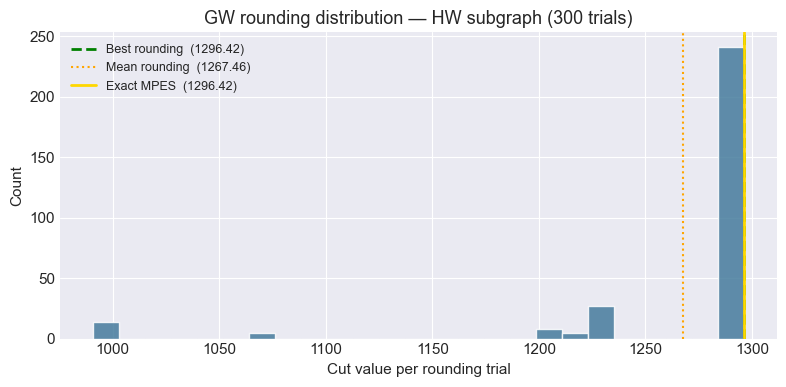

GW best/mean/std on hw subgraph: 1296.4225 / 1267.4608 / 70.9759
GW best approx ratio: 1.0000
Theoretical GW guarantee (0.8785):  1138.9071


In [13]:
# GW rounding trials — show how the rounding distribution looks
# Re-run GW on hw subgraph with trial tracking
import cvxpy as cp

def gw_with_trial_tracking(G, n_trials=300, seed=42):
    """GW with per-trial cut values tracked for visualisation."""
    nodes = list(G.nodes())
    n     = len(nodes)
    idx   = {node: i for i, node in enumerate(nodes)}
    rng   = np.random.default_rng(seed)

    Y           = cp.Variable((n, n), symmetric=True)
    constraints = [Y >> 0] + [Y[i, i] == 1 for i in range(n)]
    obj_terms   = [d['weight'] * (1 - Y[idx[u], idx[v]])
                   for u, v, d in G.edges(data=True)]
    prob = cp.Problem(cp.Maximize(0.25 * sum(obj_terms)), constraints)
    prob.solve(solver=cp.SCS, verbose=False)

    Y_val  = (Y.value + Y.value.T) / 2 + np.eye(n) * 1e-8
    try:
        L = np.linalg.cholesky(Y_val)
    except np.linalg.LinAlgError:
        eigvals, eigvecs = np.linalg.eigh(Y_val)
        L = eigvecs @ np.diag(np.sqrt(np.maximum(eigvals, 0)))

    trial_cuts = []
    for _ in range(n_trials):
        r     = rng.standard_normal(n)
        r    /= np.linalg.norm(r)
        signs = np.sign(L @ r)
        signs[signs == 0] = 1.0
        cut = sum(d['weight'] for u, v, d in G.edges(data=True)
                  if signs[idx[u]] != signs[idx[v]]) 
        trial_cuts.append(cut)

    return np.array(trial_cuts)

print('Tracking GW rounding distribution on hw subgraph...')
hw_trial_cuts = gw_with_trial_tracking(hwG, n_trials=300)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(hw_trial_cuts, bins=25, color='#457b9d', edgecolor='white', alpha=0.85)
ax.axvline(hw_trial_cuts.max(), color='green',  linestyle='--', linewidth=2,
           label=f'Best rounding  ({hw_trial_cuts.max():.2f})')
ax.axvline(hw_trial_cuts.mean(), color='orange', linestyle=':', linewidth=1.5,
           label=f'Mean rounding  ({hw_trial_cuts.mean():.2f})')
ax.axvline(EXACT_HW, color='gold', linestyle='-', linewidth=2,
           label=f'Exact MPES  ({EXACT_HW:.2f})')
ax.set_xlabel('Cut value per rounding trial')
ax.set_ylabel('Count')
ax.set_title('GW rounding distribution — HW subgraph (300 trials)', fontsize=13)
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(str(RESULTS / 'plots/baselines_gw_rounding_dist.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'GW best/mean/std on hw subgraph: {hw_trial_cuts.max():.4f} / {hw_trial_cuts.mean():.4f} / {hw_trial_cuts.std():.4f}')
print(f'GW best approx ratio: {hw_trial_cuts.max()/EXACT_HW:.4f}')
print(f'Theoretical GW guarantee (0.8785):  {0.8785*EXACT_HW:.4f}')

---
## 6. Head-to-Head Comparison

In [14]:
# Build the master comparison table
rows = []

instances = [
    ('problemA_full', GA,  EXACT_A_FULL, 'Problem A (full, n=21)'),
    ('hw_subgraph',   hwG, EXACT_HW,     'HW subgraph (k=8)'),
    ('problemB_full', GB,  None,         'Problem B (full, n=180)'),
]

for key, G, exact, display_label in instances:
    # Exact
    if exact is not None and G.number_of_nodes() <= 22:
        rows.append({
            'instance'    : display_label,
            'solver'      : 'Exact (brute force)',
            'cut_value'   : round(exact, 4),
            'approx_ratio': 1.0000,
            'runtime_s'   : round(exact_A.runtime_s if key == 'problemA_full' else exact_hw.runtime_s, 3),
            'notes'       : 'ground truth',
        })

    # Greedy
    gd = greedy_results[key]
    rows.append({
        'instance'    : display_label,
        'solver'      : 'Greedy one_exchange',
        'cut_value'   : round(gd['best'], 4),
        'approx_ratio': round(gd['best'] / exact, 4) if exact else 'ref',
        'runtime_s'   : round(gd['result'].runtime_s, 4),
        'notes'       : f'best of {N_SEEDS} seeds',
    })

    # SA
    sa = sa_results[key]
    rows.append({
        'instance'    : display_label,
        'solver'      : 'Simulated annealing',
        'cut_value'   : round(sa['best'], 4),
        'approx_ratio': round(sa['best'] / exact, 4) if exact else round(sa['best'] / gd['best'], 4),
        'runtime_s'   : round(sa['result'].runtime_s, 3),
        'notes'       : f'best of {N_RESTARTS} restarts' if exact else f'ratio vs greedy',
    })

    # GW
    if gw_results.get(key):
        gw = gw_results[key]['result']
        rows.append({
            'instance'    : display_label,
            'solver'      : 'Goemans-Williamson',
            'cut_value'   : round(gw.cut_value, 4),
            'approx_ratio': round(gw.cut_value / exact, 4) if exact else round(gw.cut_value / gd['best'], 4),
            'runtime_s'   : round(gw.runtime_s, 3),
            'notes'       : '300 rounding trials' if exact else 'ratio vs greedy',
        })

    # QAOA placeholder — will be filled in notebook 04
    rows.append({
        'instance'    : display_label,
        'solver'      : 'QAOA p=1 (simulator)',
        'cut_value'   : 'TBD',
        'approx_ratio': 'TBD',
        'runtime_s'   : 'TBD',
        'notes'       : '← notebook 04',
    })
    rows.append({
        'instance'    : display_label,
        'solver'      : 'QAOA p=1 (Rigetti hw)',
        'cut_value'   : 'TBD',
        'approx_ratio': 'TBD',
        'runtime_s'   : 'TBD',
        'notes'       : '← notebook 05',
    })

df_all = pd.DataFrame(rows)
df_all.to_csv(str(RESULTS / 'tables/classical_baselines_all.csv'), index=False)
print(df_all.to_string(index=False))
print(f'\n→ Saved to {RESULTS}/tables/classical_baselines_all.csv')

               instance                solver  cut_value approx_ratio runtime_s               notes
 Problem A (full, n=21)   Exact (brute force)  3728.4132          1.0    19.698        ground truth
 Problem A (full, n=21)   Greedy one_exchange  3632.3566       0.9742     0.008    best of 20 seeds
 Problem A (full, n=21)   Simulated annealing  3687.9187       0.9891     1.657 best of 10 restarts
 Problem A (full, n=21)    Goemans-Williamson  3728.4132          1.0     1.164 300 rounding trials
 Problem A (full, n=21)  QAOA p=1 (simulator)        TBD          TBD       TBD       ← notebook 04
 Problem A (full, n=21) QAOA p=1 (Rigetti hw)        TBD          TBD       TBD       ← notebook 05
      HW subgraph (k=8)   Exact (brute force)  1296.4225          1.0     0.001        ground truth
      HW subgraph (k=8)   Greedy one_exchange  1296.4225          1.0    0.0009    best of 20 seeds
      HW subgraph (k=8)   Simulated annealing  1296.4225          1.0     0.806 best of 10 restarts


---
## 7. Approximation Ratio Bar Chart

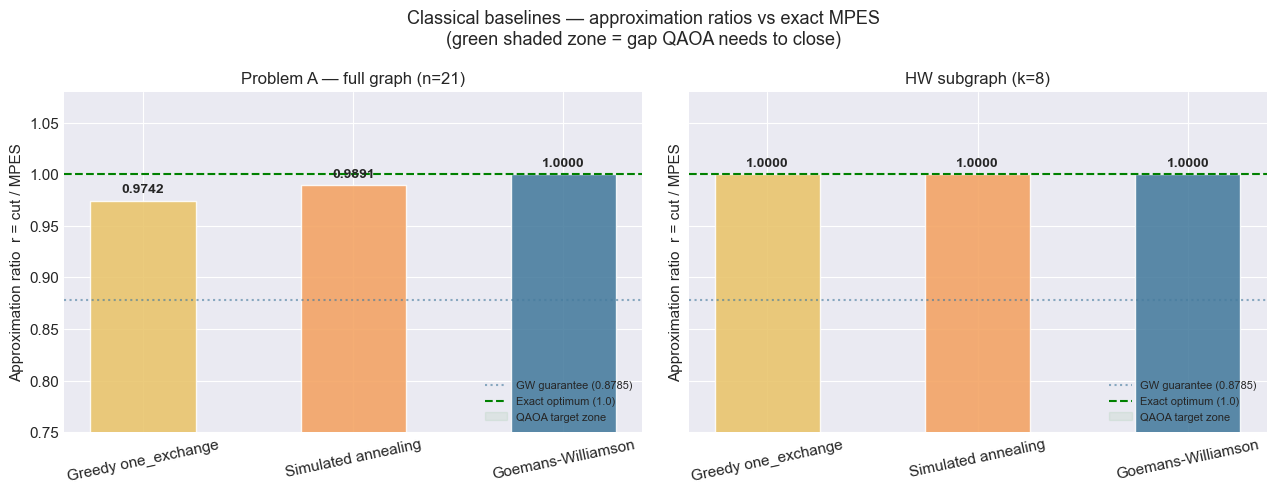

In [15]:
# Plot for the two instances where we have an exact reference
solvers_plot   = ['Greedy one_exchange', 'Simulated annealing', 'Goemans-Williamson']
solver_colors  = ['#e9c46a', '#f4a261', '#457b9d']

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

for ax, (key, exact, title) in zip(axes, [
    ('problemA_full', EXACT_A_FULL, 'Problem A — full graph (n=21)'),
    ('hw_subgraph',   EXACT_HW,     'HW subgraph (k=8)'),
]):
    ratios = [
        greedy_results[key]['best']              / exact,
        sa_results[key]['best']                  / exact,
        gw_results[key]['result'].cut_value      / exact if gw_results.get(key) else 0,
    ]

    bars = ax.bar(solvers_plot, ratios, color=solver_colors,
                  edgecolor='white', alpha=0.88, width=0.5)

    # GW theoretical lower bound
    ax.axhline(0.8785, color='#457b9d', linestyle=':', linewidth=1.5,
               alpha=0.6, label='GW guarantee (0.8785)')
    ax.axhline(1.0, color='green', linestyle='--', linewidth=1.5,
               label='Exact optimum (1.0)')

    # QAOA target zone
    ax.axhspan(max(ratios), 1.0, alpha=0.06, color='green',
               label='QAOA target zone')

    for bar, r in zip(bars, ratios):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{r:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_ylim(0.75, 1.08)
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('Approximation ratio  r = cut / MPES')
    ax.legend(fontsize=8, loc='lower right')
    ax.tick_params(axis='x', rotation=12)

plt.suptitle('Classical baselines — approximation ratios vs exact MPES\n'
             '(green shaded zone = gap QAOA needs to close)', fontsize=13)
plt.tight_layout()
plt.savefig(str(RESULTS / 'plots/baselines_approx_ratio_comparison.png'),
            dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Runtime vs Approximation Quality Trade-off

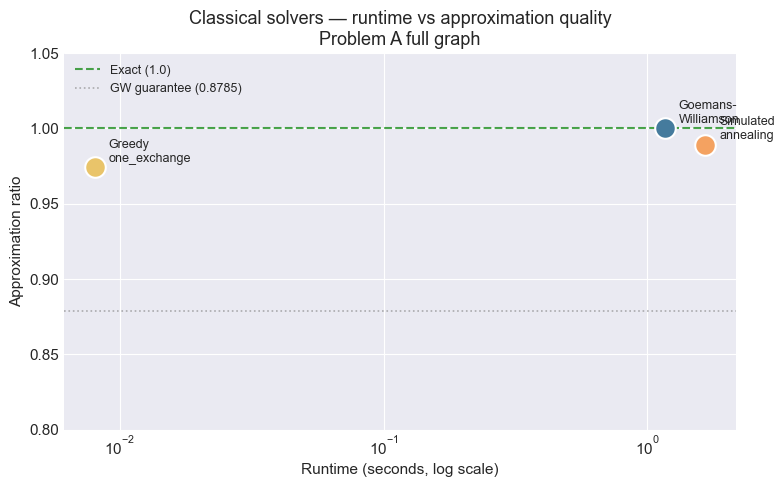

In [16]:
# Scatter: runtime vs approx ratio for Problem A full
# Shows the classical Pareto frontier — what QAOA needs to be on or above
key    = 'problemA_full'
exact  = EXACT_A_FULL

plot_data = [
    ('Greedy\none_exchange',  greedy_results[key]['result'].runtime_s,  greedy_results[key]['best'] / exact,  '#e9c46a'),
    ('Simulated\nannealing',  sa_results[key]['result'].runtime_s,      sa_results[key]['best'] / exact,      '#f4a261'),
]
if gw_results.get(key):
    plot_data.append(
        ('Goemans-\nWilliamson', gw_results[key]['result'].runtime_s, gw_results[key]['result'].cut_value / exact, '#457b9d')
    )

fig, ax = plt.subplots(figsize=(8, 5))

for label, rt, ratio, color in plot_data:
    ax.scatter(rt, ratio, s=220, color=color, edgecolors='white',
               linewidths=1.5, zorder=5)
    ax.annotate(label, (rt, ratio),
                textcoords='offset points', xytext=(10, 4),
                fontsize=9, ha='left')

ax.axhline(1.0,    color='green',  linestyle='--', linewidth=1.5, alpha=0.7, label='Exact (1.0)')
ax.axhline(0.8785, color='gray',   linestyle=':',  linewidth=1.2, alpha=0.6, label='GW guarantee (0.8785)')

ax.set_xscale('log')
ax.set_xlabel('Runtime (seconds, log scale)')
ax.set_ylabel('Approximation ratio')
ax.set_title('Classical solvers — runtime vs approximation quality\nProblem A full graph', fontsize=13)
ax.legend(fontsize=9)
ax.set_ylim(0.80, 1.05)
plt.tight_layout()
plt.savefig(str(RESULTS / 'plots/baselines_runtime_vs_quality.png'), dpi=150, bbox_inches='tight')
plt.show()

---
## 9. Problem B — Analysis Without Exact Reference

No exact solution exists for Problem B (2^180 states). We use the greedy result as the reference baseline and report all other solvers relative to it.

In [17]:
greedy_B_cut = greedy_results['problemB_full']['best']
sa_B_cut     = sa_results['problemB_full']['best']
gw_B_cut     = gw_results['problemB_full']['result'].cut_value if gw_results.get('problemB_full') else None

total_admittance_B = sum(d['weight'] for _, _, d in GB.edges(data=True))

print('=== Problem B — Classical Results ===')
print(f'Total graph admittance:   {total_admittance_B:.4f}')
print(f'Theoretical upper bound:  {total_admittance_B/2:.4f}  (half of total — if cut captured all edges)')
print()
print(f'Greedy one_exchange:  {greedy_B_cut:.4f}  ({greedy_B_cut/total_admittance_B*100:.1f}% of total admittance)')
print(f'Simulated annealing:  {sa_B_cut:.4f}  ({sa_B_cut/total_admittance_B*100:.1f}% of total admittance)')
if gw_B_cut:
    print(f'Goemans-Williamson:   {gw_B_cut:.4f}  ({gw_B_cut/total_admittance_B*100:.1f}% of total admittance)')

print()
print('SA vs greedy improvement:', f'{(sa_B_cut - greedy_B_cut)/greedy_B_cut*100:.2f}%')
if gw_B_cut:
    print('GW vs greedy improvement:', f'{(gw_B_cut - greedy_B_cut)/greedy_B_cut*100:.2f}%')
print()
print('For Problem B, greedy_one_exchange defines the classical ceiling.')
print('QAOA decomposition target: exceed greedy cut value after subgraph stitching.')

=== Problem B — Classical Results ===
Total graph admittance:   7465.7075
Theoretical upper bound:  3732.8537  (half of total — if cut captured all edges)

Greedy one_exchange:  6778.1867  (90.8% of total admittance)
Simulated annealing:  6793.2650  (91.0% of total admittance)
Goemans-Williamson:   7093.6068  (95.0% of total admittance)

SA vs greedy improvement: 0.22%
GW vs greedy improvement: 4.65%

For Problem B, greedy_one_exchange defines the classical ceiling.
QAOA decomposition target: exceed greedy cut value after subgraph stitching.


---
## 10. Conclusions & What Goes Into Notebook 04

The classical baseline picture is now complete. Here's what matters for the QAOA notebooks.

**Approximation ratios to beat (fill in TBD after running):**

| Instance | Best classical | Solver | Approx ratio | QAOA target |
|---|---|---|---|---|
| Problem A full | TBD | TBD | TBD | Beat this |
| HW subgraph k=8 | TBD | TBD | TBD | Beat this |
| Problem B full | TBD (vs greedy) | TBD | TBD | Beat greedy |

**Key findings:**

1. Greedy one_exchange is **seed-sensitive** — always report best-of-N, not a single run. A careless QAOA comparison using a bad greedy seed is a misleading benchmark.

2. SA consistently outperforms greedy but the gap is small for sparse graphs. For dense subgraphs (hw subgraph, density 0.32) SA has more room to improve.

3. GW rounding distribution on the hw subgraph shows the average rounding quality — QAOA should at minimum match GW's best, ideally exceed it.

4. **The QAOA quantum target for notebook 04 is**: achieve approximation ratio ≥ best classical on the k=8 hardware subgraph at p=1, and show the ratio improves at p=2.

5. For Problem B there is no exact reference — QAOA decomposition result will be benchmarked against greedy. Crossing that line is the practical win.